In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
color = sns.color_palette()

%matplotlib inline

eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 00:46:32.425102. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [2]:
## Read the train and test dataset and check the top few lines ##
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
print("Number of rows in train dataset : ",train_df.shape[0])
print("Number of rows in test dataset : ",test_df.shape[0])

('Number of rows in train dataset : ', 19579)
('Number of rows in test dataset : ', 8392)


/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 00:46:43.272856. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [3]:
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 00:46:55.409739. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


### Feature Engineering:

Now let us come try to do some feature engineering. This consists of two main parts.

**Meta features** - features that are extracted from the text like number of words, number of stop words, number of punctuations etc

**Text based features** - features directly based on the text / words like frequency, svd, word2vec etc.
Meta Features:

We will start with creating meta featues and see how good are they at predicting the spooky authors. The feature list is as follows:

1. Number of words in the text
2. Number of unique words in the text
3. Number of characters in the text
4. Number of stopwords
5. Number of punctuations
6. Number of upper case words
7. Number of title case words
8. Average length of the words

In [4]:
## Number of words in the text ##
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train_df["num_unique_words"] = train_df["text"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df["text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train_df["num_chars"] = train_df["text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train_df["num_stopwords"] = train_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df["num_stopwords"] = test_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the text ##
train_df["num_punctuations"] =train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["num_punctuations"] =test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train_df["num_words_upper"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train_df["num_words_title"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["num_words_title"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 00:49:15.958793. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [5]:
## Prepare the data for modeling ###
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y = train_df['author'].map(author_mapping_dict)
train_id = train_df['id'].values
test_id = test_df['id'].values

cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 00:49:48.307074. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [6]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 00:50:02.659856. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [7]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv scores : ", np.mean(cv_scores))


[0]	train-mlogloss:1.09189	test-mlogloss:1.09251
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:1.03983	test-mlogloss:1.05136
[40]	train-mlogloss:1.01688	test-mlogloss:1.03301
[60]	train-mlogloss:1.00484	test-mlogloss:1.02435
[80]	train-mlogloss:0.993582	test-mlogloss:1.01569
[100]	train-mlogloss:0.985397	test-mlogloss:1.01011
[120]	train-mlogloss:0.978863	test-mlogloss:1.00578
[140]	train-mlogloss:0.97414	test-mlogloss:1.00391
[160]	train-mlogloss:0.96952	test-mlogloss:1.00165
[180]	train-mlogloss:0.964616	test-mlogloss:0.998702
[200]	train-mlogloss:0.960827	test-mlogloss:0.997587
[220]	train-mlogloss:0.957142	test-mlogloss:0.996267
[240]	train-mlogloss:0.953026	test-mlogloss:0.994796
[260]	train-mlogloss:0.949394	test-mlogloss:0.993731
[280]	train-mlogloss:0.94612	test-mlogloss:0.992725
[300]	train-mlogloss:0.94294	test-mlogloss:0.991752
[320]	train-mlogloss:0.9

/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 00:50:24.063207. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


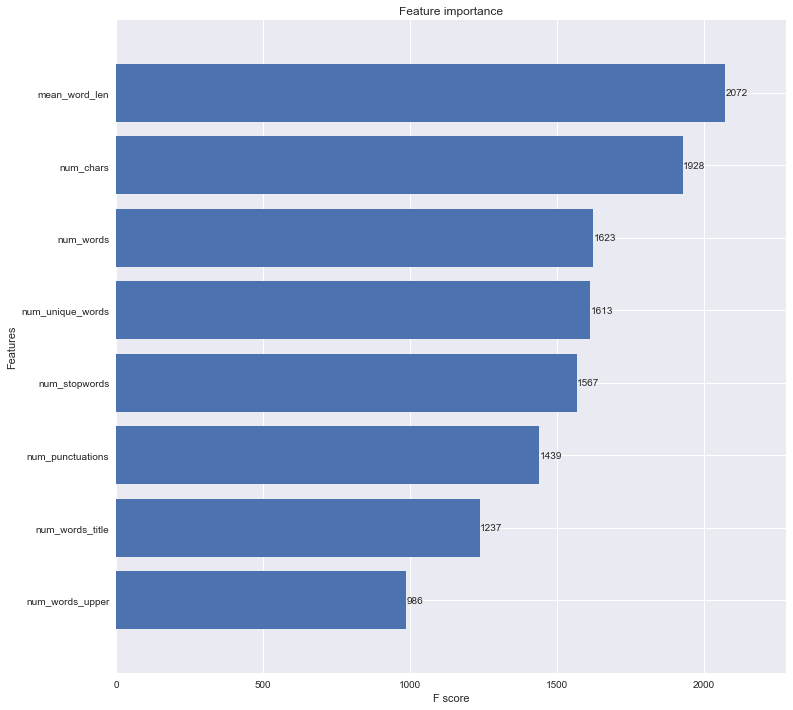

/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 00:51:30.753482. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [8]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

**Text Based Features :**

One of the basic features which we could create is tf-idf values of the words present in the text. So we can start with that one.

In [23]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 01:05:06.085026. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Now that we have got the tfidf vector, here is the tricky part. The tfidf output is a sparse matrix and so if we have to use it with other dense features, we have couple of choices.

1. We can choose to get the top 'n' features (depending on the system config) from the tfidf vectorizer, convert it into dense format and concat with other features.
2. Build a model using just the sparse features and then use the predictions as one of the features along with other dense features (a type of stacking)

Based on the dataset, one might perform better than the other.

In [24]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 01:05:12.497189. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [25]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("./meta_models/test/nb_tfidf.csv", index=False)

out_df = pd.DataFrame(pred_train)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', train_id)
out_df.to_csv("./meta_models/val/nb_tfidf.csv", index=False)

('Mean cv score : ', 0.84221619836128525)


/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 01:05:12.504342. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


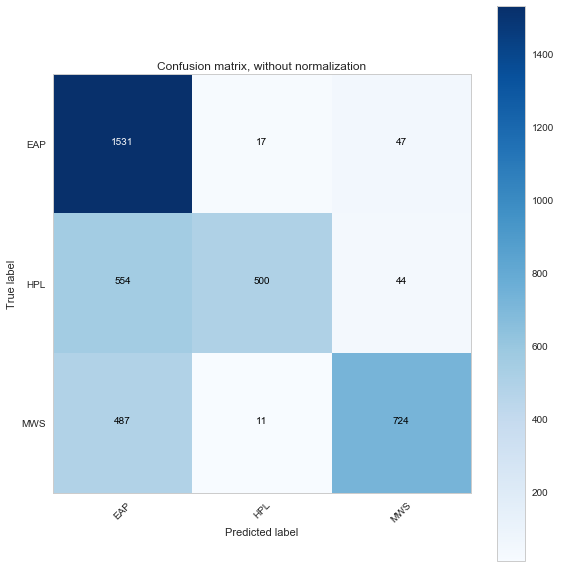

/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 01:05:17.326012. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [26]:
### Function to create confusion matrix ###
import itertools
from sklearn.metrics import confusion_matrix

### From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py #
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    sns.set_style("whitegrid", {'axes.grid' : False})
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')
plt.show()

So many instances are predicted as EAP and is highly biased towards that class.

**SVD on word TFIDF:**

Since the tfidf vectors are sparse, one another way of compressing the information and representing it in a much compact way is through SVD. Also generally SVD features have performed well for me in the past text based competitions. So we could created svd features on word tfidf and add them to our feature set.

In [13]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 00:56:38.495288. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


### Naive bayes on Count Vectorizer ###

In [14]:
### Fit transform the count vectorizer ###
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 00:58:49.271239. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [18]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("./meta_models/test/nb_cvec.csv", index=False)

out_df = pd.DataFrame(pred_train)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', train_id)
out_df.to_csv("./meta_models/val/nb_cvec.csv", index=False)

('Mean cv score : ', 0.45091841616567468)


/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 01:03:25.823099. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


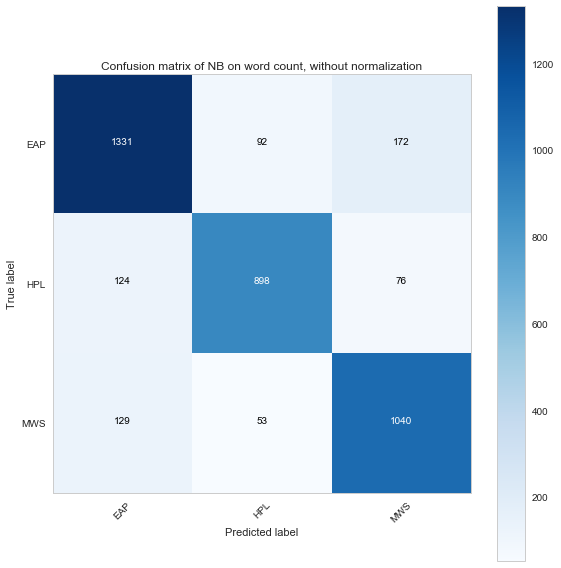

/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 01:04:53.477125. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [21]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of NB on word count, without normalization')
plt.show()

### Naive Bayes on Character Count Vectorizer:

One idea from the "data eyeballing" is that counting the special charaters might help. Instead of just counting the special characters, we can use the count vectorizer at character level to get some features. Again we can run Multinomial NB on top of it.

In [27]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = CountVectorizer(ngram_range=(1,7), analyzer='char')
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

('Mean cv score : ', 3.750763922681903)


/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 01:06:04.565697. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [28]:
out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("./meta_models/test/nb_char_cvec.csv", index=False)

out_df = pd.DataFrame(pred_train)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', train_id)
out_df.to_csv("./meta_models/val/nb_char_cvec.csv", index=False)

/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 01:07:08.432093. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


### Naive Bayes on Character Tfidf Vectorizer:

Let us also get the naive bayes predictions on the character tfidf vectorizer.

In [29]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

('Mean cv score : ', 0.7904152589474216)


/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 01:08:05.865324. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [30]:
out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("./meta_models/test/nb_char_tfidf.csv", index=False)

out_df = pd.DataFrame(pred_train)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', train_id)
out_df.to_csv("./meta_models/val/nb_char_tfidf.csv", index=False)

/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 01:08:44.141249. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


### SVD on Character TFIDF:

We could also create svd features on character tfidf features and used them for modeling.

In [31]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 01:09:09.334643. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [32]:
train_df.to_csv("../input/train_v2.csv", index=False)
test_df.to_csv("../input/test_v2.csv", index=False)

/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-11-11 01:09:53.897122. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


### What other features can we create?